<a href="https://colab.research.google.com/github/iampatgrady/Colaboratory-Analytics-Demos/blob/master/ML_Demo__Using_BQML_to_make_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using BQML to Predict Demand for NYC Taxis based on the Weather Forecast

Goal is to build a predictive model using only BigQuery standard SQL. Since this is a Python notebook, we'll use some of the features of Python to analyze the data (ie. a loss function for calculating RSME), but the model itself and it's preditive comes comes from BigQuery alone. This is called BigQuery ML (BQML) and we couldn't be more excited to try it out!

To get started, we'll take a [classic Machine Learning example](https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/CPB100/lab4a/demandforecast.ipynb) and remove the TensorFlow piece. Rest assured, TensorFlow is still being used, but it has been abstracted from view. You'll notice this model performs significantly better than the predessor, and it do this with no customatization on the model.


In [0]:
import pandas as pd
import numpy as np
import sys
from google.cloud import bigquery
from google.colab import auth
auth.authenticate_user()

You'll need to define some variables that will be used throughout the notebook. These are the GCP `project_id`, the `model_name` can be any name you prefer, and finally the `dateset_name`. The dataset needs to exist in the same project as the `project_id` and you need to have sufficient access to create and delete.

In [0]:
#@title Setup Project Variables { run: "auto", display-mode: "form" }
project_id = 'analyticspros.com:spotted-cinnamon-834' #@param {type:"string"}
dataset_name = "pats_dataset" #@param {type:"string"}
model_name = "pats_taxi_model" #@param {type:"string"}
eval_name = model_name + "_eval"
client = bigquery.Client(project=project_id)

## Create a Linear Regression Model

### Creating labeled data
This query can be run in BigQuery on its own. Try it out! This query gives us 3 years of taxi and weather data for the NYC region. Those two datasets represent our labeled data: weather as our features (or metrics) and taxi trips as our label (target, class, objective, etc...).

In [4]:
query = """
WITH trips AS (
  SELECT 
      EXTRACT (YEAR from pickup_datetime) AS year, 
      EXTRACT (DAYOFYEAR from pickup_datetime) AS daynumber 
  FROM `bigquery-public-data.new_york.tlc_yellow_trips_*`
  where _TABLE_SUFFIX between '2014' and '2016'
)
SELECT  cast(year as STRING) as year, daynumber, COUNT(1) AS numtrips FROM trips
GROUP BY year, daynumber 
"""
df = client.query(query).to_dataframe()
maxtrips = df.numtrips.max()
print "Maximum number of trips in a day: {}".format(maxtrips)

Maximum number of trips in a day: 574530


In [5]:
taxidemand = """
  -- WEATHER DATA
  with wd as (
    SELECT 
        cast(year as STRING) as year,
        EXTRACT (DAYOFYEAR FROM CAST(CONCAT(year,'-',mo,'-',da) AS TIMESTAMP)) AS daynumber, 
        MIN(EXTRACT (DAYOFWEEK FROM CAST(CONCAT(year,'-',mo,'-',da) AS TIMESTAMP))) dayofweek,
        MIN(min) mintemp, MAX(max) maxtemp, MAX(IF(prcp=99.99,0,prcp)) rain
    FROM `bigquery-public-data.noaa_gsod.gsod*`
    WHERE stn='725030'  AND _TABLE_SUFFIX between '2014' and '2016' --station id 725030=LaGuardia
    GROUP BY 1,2 
  
  -- TAXI DATA
  ), td as (  
    WITH trips AS (
      SELECT 
          EXTRACT (YEAR from pickup_datetime) AS year, 
          EXTRACT (DAYOFYEAR from pickup_datetime) AS daynumber 
      FROM `bigquery-public-data.new_york.tlc_yellow_trips_*`
      where _TABLE_SUFFIX between '2014' and '2016'
    )
    SELECT  cast(year as STRING) as year, daynumber, COUNT(1) AS numtrips FROM trips
    GROUP BY year, daynumber 
  )
  
  -- JOIN WEATHER AND TAXI DATA
    SELECT cast(wd.dayofweek as STRING) as dayofweek, 
    wd.mintemp, 
    wd.maxtemp, 
    wd.rain,
    td.numtrips / max(td.numtrips) OVER () as label 
  FROM wd, td
  where wd.year = td.year AND
  wd.daynumber = td.daynumber
  group by dayofweek, mintemp, maxtemp, rain, numtrips
"""
data = client.query(taxidemand).to_dataframe()
print data.shape

(1096, 5)


### Data Exploration

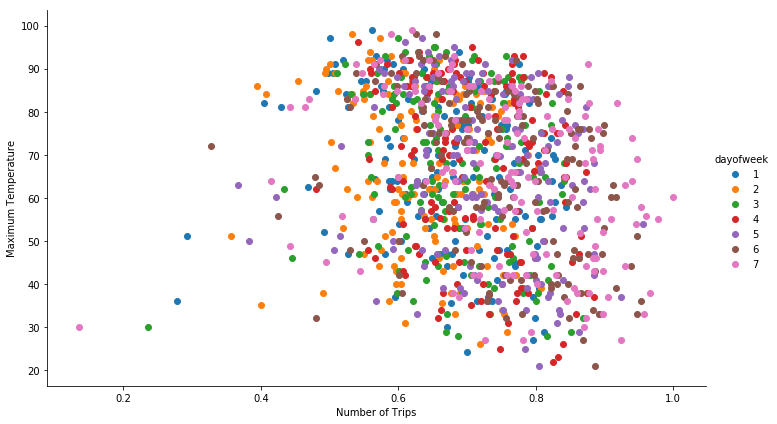

In [7]:
import seaborn
from  matplotlib import pyplot as plt
fg = seaborn.FacetGrid(data=data, hue='dayofweek', height=6,aspect=1.67)
fg = fg.map(plt.scatter, 'label', 'maxtemp').add_legend()
fg = fg.set_axis_labels(x_var="Number of Trips", y_var="Maximum Temperature")

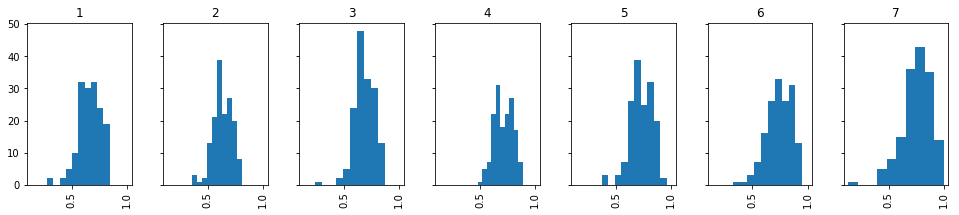

In [8]:
_ = data.hist(column='label',by='dayofweek', layout=(1,7), figsize=(16,3), sharey=True, sharex=True)

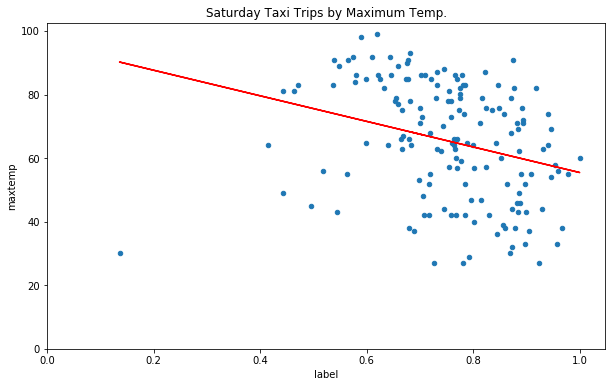

In [9]:
df = data[data.dayofweek == '7']
x = df.label
y = df.maxtemp
df.plot(kind="scatter",x="label",y="maxtemp", figsize=[10,6],ylim=0,xlim=0)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r")
plt.title("Saturday Taxi Trips by Maximum Temp.")
plt.show()

We see that trips made on a Saturday have a strong correlation with the maximum temperature. As the temperature descreases the demand for taxis increases. Our model is likely going to be able to use the predictive power found within this relationship between feature inputs and our target variable.

### Defining Model Parameters

In order to turn the above SQL into a predictive model, we simply need to `CREATE` the `MODEL` specifiying `linear_reg` or `logistic_reg`. This lets you build models for both regression (continous variable prediction) or classification (discreet variable prediction). Refer to the BQML documentation for more information on options and configuring your predictive model.

In [0]:
query = """
  CREATE OR REPLACE MODEL {0}.{1} 
    OPTIONS (
      model_type='linear_reg'
    ) as {2}
""".format(dataset_name, model_name, taxidemand)

### `CREATE MODEL` using `linear_reg`
The `for` loop will kick-off the `query_job` that has the `query` waiting to be processed. Once the job finishes it will continue through the `query_job` iterator until finished. At this point in time, the Google Cloud Python BigQuery API is throwing errors; these will be addressed in the near future.

In [34]:
query_job = client.query(query)
dataset_ref = client.dataset(dataset_name)
try: 
  for row in query_job:
    print row
except:
  print "ignoring this error: {}".format(sys.exc_info()) #  the model was successfully created

# confirm new tables exist in dataset
for i in client.list_tables(dataset_ref):
  if (i.table_id == model_name or i.table_id == eval_name):
     print i.table_id

pats_taxi_model


## Get `ml.EVALUATE()` info

### Baseline Mean Absolute Error
We want to establish a baseline to measure ourselves against. Below, we take the entire dataset (using the `taxidemand` query). Taking the mean of `numtrips` gives us an average daily trip count of `403,642`.  We'll use Pandas Mean Absolute Deviation function to calculate our MAE.

In [35]:
# Our prediction should beat the average MAE
df = client.query(taxidemand).to_dataframe()
print 'Average trips={0} with a MAE of {1}'.format(
    int(df.label.mean()*maxtrips), # scale value using the maxtrips variable
    int(df.label.mad()*maxtrips) # MAE, MAD = Mean Absolute Error, Mean Absolute Difference
)

Average trips=403642 with a MAE of 50419


### `ml.EVALUATE()`
We're looking to beat the MAE (shown below as `mean_absolute_error`)  of `50,419`. Fingers crossed!

In [36]:
query = ("select * from ml.EVALUATE(MODEL {0}.{1}, ({2}))") \
  .format(dataset_name, model_name, taxidemand)
df = client.query(query).to_dataframe()
df["mean_absolute_error"] = np.multiply(df["mean_absolute_error"],maxtrips).astype(int)
df

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,43548,0.009718,0.003547,0.064124,0.210453,0.21047


Smashed it!

### Custom Loss Function
Do you read the articles that include "the hard way" in them? Perhaps you like to to see the math in action. Below we create a custom loss function and evaluate it against our model. We'll do this using the entire dataset (as defined by `taxidemand`).  We'd expect our `model_MAE` to match the `mean_absolute_error` value returned by the `ml.EVALUATE` function above.  Fingers crossed!

In [37]:
query = """
SELECT SUM(error) / COUNT(*) as model_MAE from (
  SELECT  abs(predicted_label-label) as error
          FROM ML.PREDICT(MODEL `{0}.{1}` , ({2}))
)
""".format(dataset_name, model_name, taxidemand)
df = client.query(query).to_dataframe()
print int(df.model_MAE*maxtrips)

43548


Sure enough, the math adds up!

## Get `ml.TRAINING_INFO()` for the model
This shows us how many training procedures were needed to reach convergence, and provides various metrics associated with the training run. The system performs hyperparameter tuning automatically in order to establish the best model settings.

In [38]:
query = "select * from ml.TRAINING_INFO(MODEL {0}.{1})".format(dataset_name, model_name)
df = client.query(query).to_dataframe()
df

,training_run,iteration,loss,eval_loss,duration_ms,learning_rate
0,0,0,0.009589,0.010288,5221,None


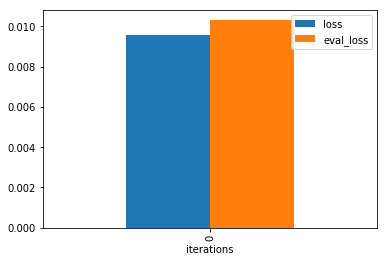

In [39]:
_ = df[['loss','eval_loss']].plot(kind='bar').set_xlabel('iterations')

## Get ml.FEATURE_INFO() for the model
This function prints out the descriptive statistics for the numerical features: min(), max(), avg(), and standard deviation. The category count shows the number of distinct values found within a categorical feature. Null count is important to note because the model will automatically convert nulls to the mean of the feature set (fairly standard practice, but could be controversial!)

In [40]:
query = "select * from ml.FEATURE_INFO(MODEL {0}.{1})".format(dataset_name, model_name)
df = client.query(query).to_dataframe()
df

,input,min,max,mean,median,stddev,category_count,null_count
0,dayofweek,NaN,NaN,NaN,NaN,NaN,7.0,0
1,mintemp,1.0,82.00,48.696756,50.0,17.919895,NaN,0
2,maxtemp,21.0,99.00,66.765324,69.1,18.344989,NaN,0
3,rain,0.0,4.88,0.110626,0.0,0.318496,NaN,0


## Get `ml.WEIGHTS()` for the `dayofweek`
We created a linear model, here are the weights applied to the features of that model.

In [41]:
query = "select * from ml.WEIGHTS(MODEL {0}.{1})".format(dataset_name, model_name)
df = client.query(query).to_dataframe()
pd.DataFrame({ 
    "processed_input" : df.processed_input,
    "weights": df.weight 
})

,processed_input,weights
0,dayofweek,NaN
1,mintemp,-0.003137
2,maxtemp,0.001394
3,rain,-0.005294
4,__INTERCEPT__,8.815234


In [42]:
query = "select * from ml.WEIGHTS(MODEL {0}.{1})".format(dataset_name, model_name)
df = client.query(query).to_dataframe()
df = pd.DataFrame(df.category_weights[0]).sort_values(by='category')
df.round(2)

,category,weight
2,1,-8.08
1,2,-8.13
6,3,-8.07
3,4,-8.04
0,5,-8.03
4,6,-8.01
5,7,-8.00


## Make Predictions
Adjust the sliders to create new input values to be evaluated by the model.  The model takes the min and max tempertatures plus rainfall for any given day of the week and returns the predicted number of taxi trips that will occur that day. 

In [58]:
#@title Select your input parameters { run: "auto", display-mode: "form" }
mintemp = 49 #@param {type:"slider", min:1, max:90, step:1}
maxtemp = 93 #@param {type:"slider", min:10, max:110, step:1}
rain = 0 #@param {type:"slider", min:0, max:5, step:0.1}
dayofweek = 4 #@param {type:"slider", min:1, max:7, step:1}

query = """
  select *
  from ml.PREDICT(
    MODEL {0}.{1},  (
      select  '{5}' as dayofweek,  
              {2} as mintemp,  
              {3} as maxtemp, 
              {4} as rain
    )
  )
""".format(dataset_name, 
           model_name, 
           mintemp,
           maxtemp,
           rain,
           dayofweek)

df = client.query(query).to_dataframe()
df["predicted_label"] = np.multiply(df["predicted_label"],maxtrips).astype(int)
df

,predicted_label,dayofweek,mintemp,maxtemp,rain
0,432094,4,49,93,0
